# Identification of organic compounds from their refractive index using deep learning

---


In [78]:
# Install keras
# !pip install keras==2.1.6

In [79]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [80]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


Importing our uv_vis augmented data, currently using github hosted file.
This data is a result of data augmentation (Synthesizing refractive index data) using the sellmeier equation.

In [81]:
uv_visAugmented = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/uv_visAugmentedData5000books.csv")
uv_visAugmented.head()

,book,wl,n,k
0,22,0.4465,1.368170,0.000000e+00
1,22,0.3916,1.373850,2.109850e-07
2,6,0.6850,1.411420,0.000000e+00
3,36,0.4850,1.362881,0.000000e+00
4,18,0.5011,1.345787,0.000000e+00


Dealing with augmented data

In [82]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
uv_visAugmented['wl_range'] = pd.cut(uv_visAugmented['wl'], [0,0.4,np.inf], labels= ['UV', 'Visible'])
uv_visAugmented.sample(3)

,book,wl,n,k,wl_range
43223,28,0.520015,1.371757,0.0,Visible
142220,55,0.456846,1.342146,0.0,Visible
80247,5,0.332593,1.520604,0.0,UV


In [83]:
# Lets select rows within UV & Visible regions - Augmented
uvAugmented = uv_visAugmented.loc[uv_visAugmented['wl_range'].isin(['UV'])]
visAugmented = uv_visAugmented.loc[uv_visAugmented['wl_range'].isin(['Visible'])]

# Data visualization and pre-processing

## Handling missing values

In [84]:
# Shape of the dataframe
df.shape

(248756, 4)

In [85]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [86]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
235935,"(C8H8)n (Polystyrene, PS)",1.77321,1.55347,0.000085,IR
124199,"C6H3Cl3 (Trichlorobenzene, TCB)",1.54334,1.54735,0.000002,IR
55043,C3H7OH (Propanol),1.43977,1.36179,0.000038,Near_IR


Let’s see how many of each class is in our data set

In [87]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

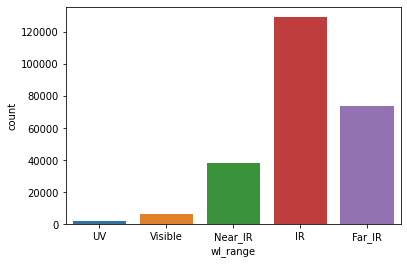

In [88]:
# Visualising
sns.countplot(x ='wl_range', data = df)

**Defining Variable for different wavelengths**

In [89]:
UV = df.loc[df['wl_range'].isin(['UV'])]
Visible = df.loc[df['wl_range'].isin(['Visible'])]
Near_IR = df.loc[df['wl_range'].isin(['Near_IR'])]
IR = df.loc[df['wl_range'].isin(['IR'])]
Far_IR = df.loc[df['wl_range'].isin(['Far_IR'])]

**Visualizing missing values of K**

In [90]:
# Counting null values of K for each region
UV_missingK = UV['k'].isna().sum()
Vis_missingK = Visible['k'].isna().sum()
nearIR_missingK = Near_IR['k'].isna().sum()
IR_missingK = IR['k'].isna().sum()
farIR_missingK = Far_IR['k'].isna().sum()

In [91]:
# Print the no of missing values of k
print('UV Null K values: ', UV_missingK)
print('Vis Null K values: ', Vis_missingK)
print('Near-IR Null K values: ', nearIR_missingK)
print('IR Null K values: ', IR_missingK)
print('Far-IR Null K values: ', farIR_missingK)

UV Null K values:  1066
Vis Null K values:  5182
Near-IR Null K values:  2794
IR Null K values:  419
Far-IR Null K values:  184


In [92]:
# Determining the percent of missing values in each wavelength region
# Number of rows is given by len(dataframe)

# Print the percents of available k values per wavelength region
print('Percents of available extinction coefficients (k) per wavelength region \n ')

print('Percent of k in UV: ', round((len(UV) - UV_missingK )/ len(UV) * 100, 2))
print('Percent of k in Visible: ', round((len(Visible) - Vis_missingK ) / len(Visible) * 100, 2))
print('Percent of k in Near-IR: ', round((len(Near_IR) - nearIR_missingK )/ len(Near_IR) * 100, 2))
print('Percent of k in IR: ', round((len(IR) - IR_missingK ) / len(IR) * 100, 2))
print('Percent of k in Far-IR: ', round((len(Far_IR) - farIR_missingK )/ len(Far_IR) * 100, 2))

Percents of available extinction coefficients (k) per wavelength region 
 
Percent of k in UV:  41.01
Percent of k in Visible:  17.33
Percent of k in Near-IR:  92.62
Percent of k in IR:  99.68
Percent of k in Far-IR:  99.75


In [93]:
# Determining the percent of missing values in UV & Visible Augmented data
# Number of rows is given by len(dataframe)

# Print the percents of missing k values per wavelength region
print('Percents of available extinction coefficients (k) per wavelength region - Augmented data\n ')

# Missing values for augmented data = missing values before augmentantion + added synthetic data

print('Percent of k in UV-Augmented: ', round((len(uvAugmented) - (UV_missingK + 130507) ) / len(uvAugmented) * 100, 2))
print('Percent of k in Visible-Augmented: ', round((len(visAugmented) - (Vis_missingK + 115187)) / len(visAugmented) * 100, 2))

Percents of available extinction coefficients (k) per wavelength region - Augmented data
 
Percent of k in UV-Augmented:  0.56
Percent of k in Visible-Augmented:  0.07


**Plotting Percent of missing k vs accuracies**

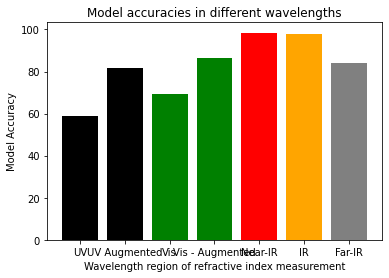

In [94]:
fig, ax = plt.subplots()

wavelengths = ['UV','UV Augmented', 'Vis', 'Vis - Augmented', 'Near-IR',
          'IR', 'Far-IR']
model_accuracy = [59, 81.49, 69.22, 86.6, 98.44, 97.72, 84.09 ]
bar_labels = ['UV','UV Augmented', 'Vis', 'Vis - Augmented',
              'Near-IR', 'IR', 'Far-IR']
bar_colors = ['black', 'black', 'green', 'green', 'red', 'orange', 'grey']

ax.bar(wavelengths, model_accuracy, label=bar_labels, color = bar_colors)

ax.set_ylabel('Model Accuracy')
ax.set_xlabel('Wavelength region of refractive index measurement')

ax.set_title('Model accuracies in different wavelengths')
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

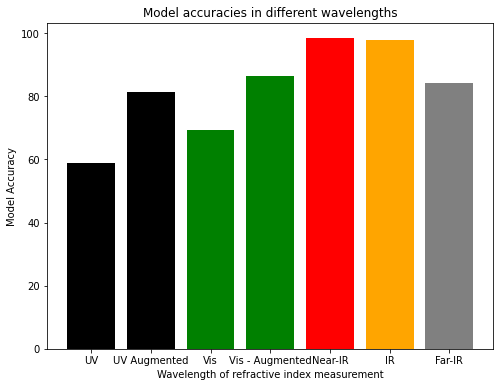

In [95]:
fig, ax = plt.subplots()

wavelengths = ['UV','UV Augmented', 'Vis', 'Vis - Augmented', 'Near-IR',
          'IR', 'Far-IR']
model_accuracy = [59, 81.49, 69.22, 86.6, 98.44, 97.72, 84.09 ]
bar_labels = ['UV','UV Augmented', 'Vis', 'Vis - Augmented',
              'Near-IR', 'IR', 'Far-IR']
bar_colors = ['black', 'black', 'green', 'green', 'red', 'orange', 'grey']

ax.bar(wavelengths, model_accuracy, label=bar_labels, color = bar_colors)

ax.set_ylabel('Model Accuracy')
ax.set_xlabel('Wavelength of refractive index measurement')

ax.set_title('Model accuracies in different wavelengths')
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

**Describing The data**

In [96]:
# Describe new df with only Near-Infrared data
Far_IR.describe()

,wl,n,k
count,73576.000000,73576.000000,73392.000000
mean,8.955725,1.442561,0.017873
std,5.749281,0.096021,0.059402
min,4.000030,0.805570,0.000000
25%,5.123000,1.367920,0.000579
50%,7.071680,1.450935,0.002123
75%,11.079000,1.512940,0.011336
max,200.000000,2.206960,1.224330


In [97]:
Far_IR.shape

(73576, 5)

***Some conclusions & disccusions on complex refractive index effect to performance***

---

**1. The complex refractive index in combination with ANN can accurately identify organic compounds.
 - Because Complex refractive index is a complete description of the scattering and absorption of a wavelength in a media. The imaginary part of a refractive index is related to the absorption coefficient by 4πmi/λ. For a real refractive index, only scattering can take place. For a complex index, both scattering and absorption are possible. Hence complex refractive index provides more info which facilitates the machine learning model to accurately identify the organic compound.
https://www.sciencedirect.com/topics/earth-and-planetary-sciences/refractivity
 
2. Factors affecting accuracies 
 - Proportional to amount of training data (Only incase of very low training data, weakly applies to large amounts of data)
 - Complex RI (Extent of Fully defined real and imaginary parts)

  Why accuracies are in the order observed?

* ( Near -IR > IR  > Far -IR > Visible> UV) - Real data.
* ( Near -IR > IR > Visible > Far -IR > UV) - Augmented UV & Vis.

 - In first case (real data), there is very high percent of missing values of K values in UV & Visible regions as compared to the IR regions (Near-IR, IR and Far-IR). So the complex RI cannot be fully determined in the UV & Visible regions, hence low performance of their ANN classifiers.

 - With data augmentation in the UV & Visible regions, the model accuracies increase significantly due to large amount of data used for their training.

 The model in visible region performed slightly better than in the Far-IR model, this maybe due to artificially synthesized data which is not a real representation of experimental data, hence the model may easily learn the pattens in data because it is derived from a single theroretical equation(Sellmeier equation).**